In [35]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import matplotlib.cm
import cmocean
import shapely
import pandas
import geopandas

In [2]:
file_dir = '/Users/baird/Dropbox/_data_observations/CALIPSO/'
#file_dir = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/'

In [3]:
file_list = sorted(glob.glob(file_dir+'/*.hdf'))

In [4]:
file_list

['/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_01kmCLay-Standard-V4-10.2018-05-31T17-55-21ZN.hdf',
 '/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4-10.2018-05-31T17-55-21ZN.hdf']

In [5]:
# ===== open file, pull out specific data set
gdal_file = gdal.Open(file_list[1])
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter

In [6]:
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()

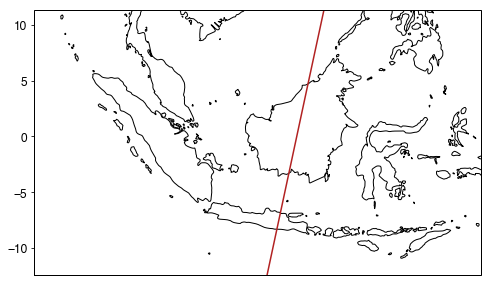

In [7]:
ds = xarray.open_dataset(file_list[1])

lat = ds['Latitude'].sel(fakeDim3=1).values
lon = ds['Longitude'].sel(fakeDim5=1).values


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

In [8]:
p_data = ds['Pressure'].values

In [9]:
# cod_data = ds['Column_Optical_Depth_Cloud_532'].values
# ec_data = ds['Extinction_Coefficient_532'].values
# rh_data = ds['Relative_Humidity'].values
# igbp_data = ds['IGBP_Surface_Type'].values
# clf_data = ds['Cloud_Layer_Fraction'].values
# avd_data = ds['Atmospheric_Volume_Description'].values
# tbc_data = ds['Total_Backscatter_Coefficient_532'].values
# ciab_data = ds['Column_Integrated_Attenuated_Backscatter_532'].values
# iwc_data = ds['Ice_Water_Content_Profile'].values

In [10]:
step = 1e-4
one = numpy.arange(1e-4,9e-4+step,step)

step = 0.5e-3
two = numpy.arange(1e-3,8e-3+step,step)

step = 1e-2
three = numpy.arange(1e-2,1e-1+step,step)

bounds = list(numpy.concatenate((one,two,three)))

In [11]:
cmap = matplotlib.cm.Spectral
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

In [12]:
# make color map
minval=0. # for inferno:  0.18
maxval=0.9 # for inferno: 1.0
n=256
full_cmap = cmocean.cm.ice_r #mp.get_cmap('blues')
cmap_partial = matplotlib.colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=full_cmap.name, a=minval, b=maxval), full_cmap(numpy.linspace(minval, maxval, n)))

In [13]:
gdal_tbc_data_filtered = numpy.copy(gdal_tbc_data)
gdal_tbc_data_filtered[gdal_tbc_data_filtered<0] = numpy.nan
gdal_tbc_data_filtered[gdal_tbc_data_filtered>1.5] = numpy.nan

/Users/baird/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


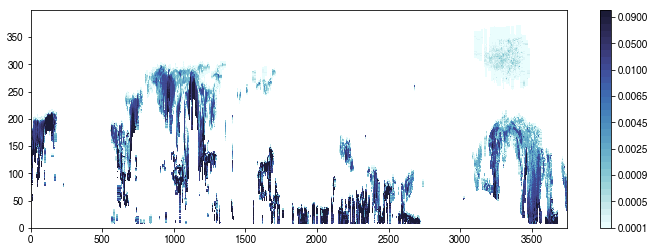

In [14]:
fig = mp.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot = ax.pcolormesh(gdal_tbc_data_filtered.T[::-1,:], norm=norm, cmap=cmap_partial)

mp.colorbar(plot, norm=norm)

In [15]:
lat_2d = numpy.repeat(lat, p_data.shape[1]).reshape((p_data.shape))

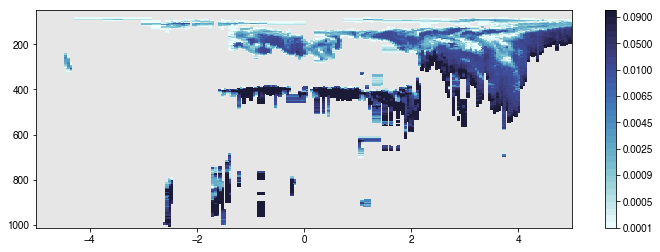

In [16]:
fig = mp.figure(figsize=(12,4))

ax = fig.add_subplot(111)
plot = ax.pcolormesh(lat_2d.T[::-1,:], p_data.T[::-1,:], \
                     gdal_tbc_data_filtered.T[::-1,:], norm=norm, cmap=cmap_partial)

ax.set_facecolor('0.9')
ax.set_ylim(1013.25,50)
ax.set_xlim(-5,5)
fig.colorbar(plot)

### regridding example

https://stackoverflow.com/questions/34408293/2-d-interpolation-ignoring-nan-values

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata

    x =   np.array([[9.19632, 9.62141, 10.0829,np.isnan,np.isnan],
        [9.21164, 9.64347, 10.1392, 10.5698,np.isnan],
        [9.22175, 9.65439, 10.1423, 10.6301, 11.0323],
        [9.21632, 9.67060, 10.1474, 10.6230, 11.0818]])

    y =  np.array([[11.5466,11.6485,11.7619,np.isnan,np.isnan],
        [12.4771, 12.5460, 12.5453, 12.7142,np.isnan],
        [13.5578, 13.5581, 13.5505, 13.5309, 13.6081],
        [14.5653, 14.5504, 14.5036, 14.5145, 14.5060]])

    z = np.array([[0.466113, 0.0484404, -0.385355,np.isnan,np.isnan],
        [0.366125, -0.160165, -0.548668, -0.888301,np.isnan],
        [-0.0970777, -0.346734, -0.826576, -1.08412, -1.33129],
        [-0.259981, -0.586938, -1.03477, -1.32384, -1.61500]])

    x=x.ravel()              #Flat input into 1d vector
    x=list(x[x!=np.isnan])   #eliminate any NaN
    y=y.ravel()
    y=list(y[y!=np.isnan])
    z=z.ravel()
    z=list(z[z!=np.isnan])


    xnew = np.arange(9,11.5, 0.01)
    ynew = np.arange(9,15, 0.01)
    znew = griddata((x, y), z, (xnew[None,:], ynew[:,None]), method='linear')



    levels = np.linspace(min(z), max(z), 15)
    plt.ylabel('Y', size=15)
    plt.xlabel('X', size=15)
    cmap = plt.cm.jet_r
    cs = plt.contourf(xnew, ynew, znew, levels=levels, cmap=cmap)
    cbar = plt.colorbar(cs)
    cbar.set_label('Z', rotation=90, fontsize=15) # gas fraction
    plt.show()

### regridding

In [ ]:
z = gdal_tbc_data_subset.ravel()

x = lat_2d.ravel()
#x = x[~numpy.isnan(z)]

y = p_data_subset.ravel()
#y = y[~numpy.isnan(z)]

#z = z[~numpy.isnan(z)]


xnew = numpy.arange(-3.5,5,0.1)
ynew = numpy.arange(113.25,1013.251,5)

znew = scipy.interpolate.griddata((x,y),z, (xnew[None,:],ynew[:,None]), method='linear')

fig = mp.figure(figsize=(8,4))

ax = fig.add_subplot(111)
plot = ax.pcolormesh(xnew,ynew,znew, norm=norm, cmap=cmap_partial)

fig.colorbar(plot)

ax.set_facecolor('0.5')
ax.set_ylim(1013.25,50)

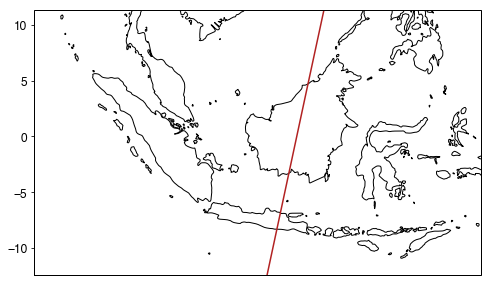

In [19]:
ds = xarray.open_dataset(file_list[1])

lat = ds['Latitude'].sel(fakeDim3=1).values
lon = ds['Longitude'].sel(fakeDim5=1).values

track_geom = shapely.geometry.LineString(zip(lon,lat))
#track_geom_crop = track_geom.intersection(borneo_main_geom)

ds.close()

#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

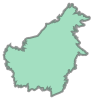

In [36]:
#states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states = geopandas.read_file('/Users/baird/Dropbox/_data_NATURAL_EARTH/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]

list(borneo_gdf_union.geoms)[15]

In [20]:
track_geom = shapely.geometry.LineString(zip(lon,lat))
#track_geom_crop = track_geom.intersection(borneo_main_geom)

ds.close()

# open stuff in gdal to get proper values...
gdal_file = gdal.Open(file)
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter coefficient
gdal_cmsp_ds = gdal.Open(gdal_subdatasets[43][0]) # Cloud_Multiple_Scattering_Profile_532

gdal_tbc_data = gdal_tbc_ds.ReadAsArray()
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_cmsp_data = gdal_cmsp_ds.ReadAsArray()

# crop stuff
lon_crop,lat_crop = track_geom_crop.coords.xy
lat_crop = numpy.array(lat_crop)
lon_crop = numpy.array(lon_crop)

lon_left = lon_crop[0]
lon_right = lon_crop[-1]

lon_left_idx = numpy.abs(lon-lon_left).argmin()
lon_right_idx = numpy.abs(lon-lon_right).argmin()

lon_subset = lon[lon_left_idx:lon_right_idx+1]
lat_subset = lat[lon_left_idx:lon_right_idx+1]

p_data_subset = p_data[lon_left_idx:lon_right_idx+1,:]
lat_2d = numpy.repeat(lat_subset, p_data_subset.shape[1]).reshape((p_data_subset.shape))

gdal_tbc_data_subset = gdal_tbc_data[lon_left_idx:lon_right_idx+1]
gdal_clf_data_subset = gdal_clf_data[lon_left_idx:lon_right_idx+1]
gdal_cmsp_data_subset = gdal_cmsp_data[lon_left_idx:lon_right_idx+1]

NameError: name 'borneo_main_geom' is not defined

In [27]:
import scipy

In [29]:
scipy.interpolate.griddata()

<module 'scipy.interpolate' from '/Users/baird/miniconda3/lib/python3.6/site-packages/scipy/interpolate/__init__.py'>

In [26]:
lat_2d.shape
p_data.shape

(3744, 399)